# Système de Classification et Vérification d'Identité avec t-SNE

## 📋 Objectif
Créer un système qui :
1. Extrait les embeddings (représentations latentes) des visages
2. Visualise ces embeddings en 2D avec t-SNE
3. **Permet de tester une nouvelle image** et détermine si elle appartient à une identité existante
4. Affiche le nouveau point sur le graphique t-SNE existant

## 1️⃣ Imports et Configuration

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, FancyArrowPatch
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuration matplotlib
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11
sns.set_style('whitegrid')

## 2️⃣ Chargement des Données Olivetti

In [4]:
# Chargement du dataset LFW local
import os
from tensorflow.keras.preprocessing import image

DATA_PATH = r"c:\Users\marwa\OneDrive\Desktop\moprh\big_dataset_lfw"
IMG_SIZE = (224, 224)

print("📥 Chargement du dataset LFW...")

# Charger les images depuis les sous-dossiers (1 dossier = 1 identité)
images_list = []
labels_list = []
class_names = sorted([d for d in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, d))])

# Créer un mapping nom -> label numérique
label_map = {name: idx for idx, name in enumerate(class_names)}

for class_name in class_names:
    class_path = os.path.join(DATA_PATH, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            # Charger l'image en RGB et resize à 224x224
            img = image.load_img(img_path, target_size=IMG_SIZE, color_mode='rgb')
            img_array = image.img_to_array(img).astype(np.uint8)
            images_list.append(img_array)
            labels_list.append(label_map[class_name])
        except Exception as e:
            print(f"⚠️ Erreur avec {img_path}: {e}")

images_raw = np.array(images_list)
labels_raw = np.array(labels_list)

print(f"✅ Dataset chargé: {images_raw.shape[0]} images")
print(f"   Identités uniques: {len(np.unique(labels_raw))}")
print(f"   Shape des images: {images_raw.shape}")

📥 Chargement du dataset LFW...
✅ Dataset chargé: 2000 images
   Identités uniques: 5
   Shape des images: (2000, 224, 224, 3)


## 3️⃣ Séparation en Groupes P (Proxies) et N (Externes)

In [6]:
# Répartition équilibrée entre Proxies (P) et Externes (N)
unique_labels = np.unique(labels_raw)
n_identities = len(unique_labels)

print(f"📊 Identités disponibles: {n_identities}")
print(f"   Labels: {unique_labels}")

# Séparer les identités en deux groupes
split_point = n_identities // 2
labels_P_ids = unique_labels[:split_point]  # Première moitié des identités
labels_N_ids = unique_labels[split_point:]  # Seconde moitié des identités

# --- Groupe P (Proxies) ---
indices_P = np.where(np.isin(labels_raw, labels_P_ids))[0]
if len(indices_P) > 200:
    indices_P = np.random.choice(indices_P, 200, replace=False)
imgs_P = images_raw[indices_P]
labels_P = labels_raw[indices_P]

# --- Groupe N (Externes) ---
indices_N = np.where(np.isin(labels_raw, labels_N_ids))[0]
if len(indices_N) > 200:
    indices_N = np.random.choice(indices_N, 200, replace=False)
imgs_N = images_raw[indices_N]
labels_N = labels_raw[indices_N]

print(f"\n👥 Groupe P (Proxies): {len(imgs_P)} images ({len(labels_P_ids)} identités)")
print(f"👥 Groupe N (Externes): {len(imgs_N)} images ({len(labels_N_ids)} identités)")

📊 Identités disponibles: 5
   Labels: [0 1 2 3 4]

👥 Groupe P (Proxies): 200 images (2 identités)
👥 Groupe N (Externes): 200 images (3 identités)


## 4️⃣ Préparation des Images (Resize + RGB)

In [8]:
def prepare_images(imgs):
    """Les images LFW sont déjà en 224x224 RGB - on les garde telles quelles"""
    return imgs.astype(np.float32)

X_P = prepare_images(imgs_P)
X_N = prepare_images(imgs_N)

# Labels pour visualisation (0=Proxies, 1=Externes)
y_P = np.zeros(len(X_P), dtype=int)
y_N = np.ones(len(X_N), dtype=int)

# Fusion
X_all = np.concatenate([X_P, X_N], axis=0)
y_all = np.concatenate([y_P, y_N], axis=0)
labels_all = np.concatenate([labels_P, labels_N], axis=0)

print(f"✅ Données préparées: {X_all.shape}")
print(f"   Identités uniques dans le dataset: {len(np.unique(labels_all))}")

✅ Données préparées: (400, 224, 224, 3)
   Identités uniques dans le dataset: 5


## 5️⃣ Construction du Modèle d'Extraction d'Embeddings

Nous utilisons **MobileNetV2** pré-entraîné sur ImageNet comme extracteur de features.

In [9]:
# Data augmentation (optionnel, pour l'entraînement)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1),
])

# Modèle de base (MobileNetV2)
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze les poids

# Modèle d'extraction d'embeddings
embedding_model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Rescaling(1./127.5, offset=-1),  # Normalisation [-1, 1]
    base_model,
    layers.GlobalAveragePooling2D(),  # Vecteur de dimension 1280
], name="embedding_extractor")

print("✅ Modèle d'extraction créé")
print(f"   Dimension des embeddings: {embedding_model.output_shape[1]}")
embedding_model.summary()

✅ Modèle d'extraction créé
   Dimension des embeddings: 1280


Model: "embedding_extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

## 6️⃣ Extraction des Embeddings du Dataset

In [10]:
print("🔄 Extraction des embeddings (cela peut prendre 1-2 minutes)...")
embeddings_all = embedding_model.predict(X_all, batch_size=32, verbose=1)

print(f"✅ Embeddings extraits: {embeddings_all.shape}")
print(f"   Norme moyenne: {np.linalg.norm(embeddings_all, axis=1).mean():.4f}")

🔄 Extraction des embeddings (cela peut prendre 1-2 minutes)...
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 840ms/step
✅ Embeddings extraits: (400, 1280)
   Norme moyenne: 28.7060


## 7️⃣ Réduction de Dimension avec t-SNE

In [11]:
print("🔄 Lancement de t-SNE (cela peut prendre quelques secondes)...")

tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=30,
    n_iter=2000,
    verbose=1
)

embeddings_2d = tsne.fit_transform(embeddings_all)

print(f"✅ Réduction t-SNE terminée: {embeddings_2d.shape}")

🔄 Lancement de t-SNE (cela peut prendre quelques secondes)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.001s...
[t-SNE] Computed neighbors for 400 samples in 1.075s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 6.285122
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.461151
[t-SNE] KL divergence after 2000 iterations: 0.833252
✅ Réduction t-SNE terminée: (400, 2)


## 8️⃣ Visualisation t-SNE Initiale

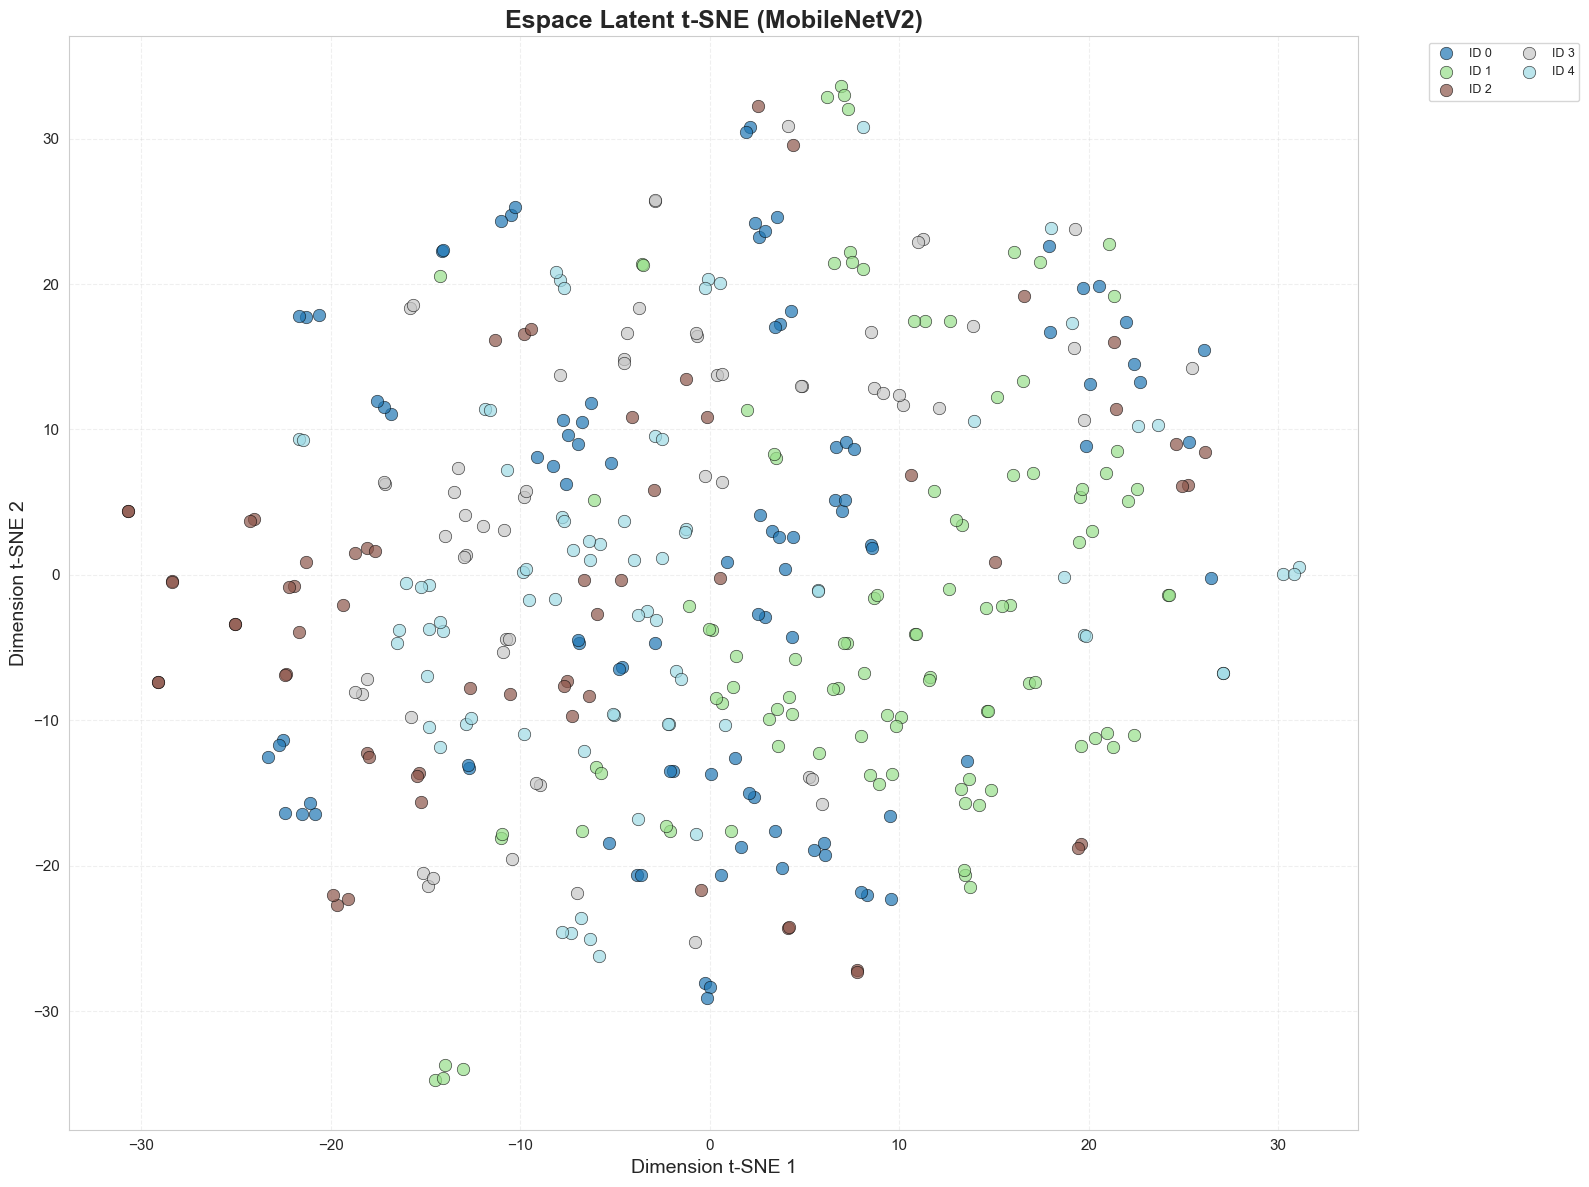

In [12]:
def plot_tsne_by_identity(embeddings_2d, labels, title="Visualisation t-SNE"):
    """Plot t-SNE coloré par identité"""
    plt.figure(figsize=(16, 12))
    
    unique_ids = np.unique(labels)
    palette = plt.cm.get_cmap('tab20', len(unique_ids))
    
    for idx, label_id in enumerate(unique_ids):
        mask = labels == label_id
        plt.scatter(
            embeddings_2d[mask, 0],
            embeddings_2d[mask, 1],
            c=[palette(idx)],
            label=f'ID {label_id}',
            alpha=0.7,
            s=80,
            edgecolors='black',
            linewidths=0.5
        )
    
    plt.title(title, fontsize=18, fontweight='bold')
    plt.xlabel("Dimension t-SNE 1", fontsize=14)
    plt.ylabel("Dimension t-SNE 2", fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=2)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualisation
plot_tsne_by_identity(
    embeddings_2d,
    labels_all,
    title="Espace Latent t-SNE (MobileNetV2)"
)

## 9️⃣ Classe de Vérification d'Identité

### 🎯 Principe
1. Pour chaque identité, on calcule un **centroïde** (moyenne des embeddings)
2. On définit un **seuil de distance** basé sur les distances intra-classe
3. Pour une nouvelle image :
   - On extrait son embedding
   - On calcule la distance au centroïde le plus proche
   - Si distance < seuil → **Identité reconnue**
   - Sinon → **Identité inconnue**

In [13]:
class IdentityVerifier:
    """
    Système de vérification d'identité basé sur les embeddings
    """
    
    def __init__(self, embeddings, labels, embeddings_2d, threshold_percentile=15):
        """
        Args:
            embeddings: Embeddings haute dimension (N, D)
            labels: Labels des identités (N,)
            embeddings_2d: Embeddings 2D pour visualisation (N, 2)
            threshold_percentile: Percentile pour définir le seuil
        """
        self.embeddings = embeddings
        self.labels = labels
        self.embeddings_2d = embeddings_2d
        
        # Identités uniques
        self.unique_ids = np.unique(labels)
        
        # Calcul des centroïdes (moyenne par identité)
        self.centroids = {}
        self.centroids_2d = {}
        
        for label_id in self.unique_ids:
            mask = labels == label_id
            self.centroids[label_id] = embeddings[mask].mean(axis=0)
            self.centroids_2d[label_id] = embeddings_2d[mask].mean(axis=0)
        
        # Calcul du seuil de distance
        distances_intra = []
        for label_id in self.unique_ids:
            mask = labels == label_id
            id_embeddings = embeddings[mask]
            centroid = self.centroids[label_id]
            
            # Distance de chaque point au centroïde de sa classe
            dists = np.linalg.norm(id_embeddings - centroid, axis=1)
            distances_intra.extend(dists)
        
        self.threshold = np.percentile(distances_intra, threshold_percentile)
        
        print(f"✅ Vérificateur initialisé")
        print(f"   Nombre d'identités: {len(self.unique_ids)}")
        print(f"   Seuil de vérification: {self.threshold:.4f}")
        print(f"   Distance intra-classe moyenne: {np.mean(distances_intra):.4f}")
    
    def verify_identity(self, new_embedding):
        """
        Vérifie si un embedding correspond à une identité existante
        
        Returns:
            dict avec:
                - is_known: bool
                - identity: int ou None
                - distance: float
                - confidence: float (0-1)
        """
        # Trouver le centroïde le plus proche
        min_distance = float('inf')
        best_identity = None
        
        for label_id, centroid in self.centroids.items():
            dist = np.linalg.norm(new_embedding - centroid)
            if dist < min_distance:
                min_distance = dist
                best_identity = label_id
        
        # Décision
        is_known = min_distance < self.threshold
        confidence = max(0, 1 - (min_distance / (2 * self.threshold)))
        
        return {
            'is_known': is_known,
            'identity': best_identity if is_known else None,
            'distance': min_distance,
            'confidence': confidence,
            'threshold': self.threshold,
            'closest_centroid': best_identity
        }
    
    def project_to_2d(self, new_embedding):
        """
        Projette un nouvel embedding dans l'espace t-SNE 2D
        (approximation par interpolation basée sur les voisins)
        """
        # Trouver les 10 plus proches voisins
        from sklearn.neighbors import NearestNeighbors
        nn = NearestNeighbors(n_neighbors=10)
        nn.fit(self.embeddings)
        distances, indices = nn.kneighbors([new_embedding])
        
        # Pondération inversement proportionnelle à la distance
        weights = 1 / (distances[0] + 1e-6)
        weights = weights / weights.sum()
        
        # Position 2D = moyenne pondérée des voisins
        new_pos_2d = (self.embeddings_2d[indices[0]] * weights[:, np.newaxis]).sum(axis=0)
        
        return new_pos_2d
    
    def visualize_verification(self, new_embedding_2d, verification_result,
                               new_image=None, title="Vérification d'Identité"):
        """
        Visualise le résultat de la vérification sur le graphique t-SNE
        """
        fig = plt.figure(figsize=(18, 10))
        
        if new_image is not None:
            # Deux sous-graphiques
            gs = fig.add_gridspec(1, 2, width_ratios=[1, 3])
            ax_img = fig.add_subplot(gs[0])
            ax_tsne = fig.add_subplot(gs[1])
            
            # Afficher l'image
            if new_image.shape[-1] == 1:
                ax_img.imshow(new_image.squeeze(), cmap='gray')
            else:
                ax_img.imshow(new_image.astype(np.uint8))
            ax_img.axis('off')
            ax_img.set_title('Image Testée', fontsize=14, fontweight='bold')
        else:
            ax_tsne = plt.gca()
        
        # Palette de couleurs
        palette = plt.cm.get_cmap('tab20', len(self.unique_ids))
        
        # Plot des points existants
        for idx, label_id in enumerate(self.unique_ids):
            mask = self.labels == label_id
            ax_tsne.scatter(
                self.embeddings_2d[mask, 0],
                self.embeddings_2d[mask, 1],
                c=[palette(idx)],
                label=f'ID {label_id}',
                alpha=0.6,
                s=70,
                edgecolors='black',
                linewidths=0.5
            )
            
            # Centroïde (étoile)
            centroid_2d = self.centroids_2d[label_id]
            ax_tsne.scatter(
                centroid_2d[0], centroid_2d[1],
                c=[palette(idx)],
                marker='*',
                s=400,
                edgecolors='black',
                linewidths=2,
                zorder=5
            )
        
        # Nouveau point
        is_known = verification_result['is_known']
        color = 'lime' if is_known else 'red'
        marker = 'D' if is_known else 'X'
        
        ax_tsne.scatter(
            new_embedding_2d[0], new_embedding_2d[1],
            c=color,
            marker=marker,
            s=500,
            edgecolors='black',
            linewidths=3,
            label='🔍 Nouveau point',
            zorder=10
        )
        
        # Ligne vers le centroïde le plus proche
        closest_id = verification_result['closest_centroid']
        if closest_id is not None:
            centroid_2d = self.centroids_2d[closest_id]
            ax_tsne.plot(
                [new_embedding_2d[0], centroid_2d[0]],
                [new_embedding_2d[1], centroid_2d[1]],
                'k--' if is_known else 'r--',
                linewidth=2,
                alpha=0.7,
                label=f'Distance: {verification_result["distance"]:.3f}'
            )
        
        # Box d'information
        status = "✅ RECONNUE" if is_known else "❌ INCONNUE"
        info_text = f"{status}\n"
        info_text += f"Distance: {verification_result['distance']:.4f}\n"
        info_text += f"Seuil: {verification_result['threshold']:.4f}\n"
        info_text += f"Confiance: {verification_result['confidence']*100:.1f}%\n"
        
        if is_known:
            info_text += f"Identité: {verification_result['identity']}"
        else:
            info_text += f"Centroïde le plus proche: ID {closest_id}"
        
        bbox_color = 'lightgreen' if is_known else 'lightcoral'
        ax_tsne.text(
            0.02, 0.98, info_text,
            transform=ax_tsne.transAxes,
            fontsize=13,
            verticalalignment='top',
            fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor=bbox_color, alpha=0.9, edgecolor='black', linewidth=2)
        )
        
        ax_tsne.set_title(title, fontsize=18, fontweight='bold')
        ax_tsne.set_xlabel("Dimension t-SNE 1", fontsize=14)
        ax_tsne.set_ylabel("Dimension t-SNE 2", fontsize=14)
        ax_tsne.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
        ax_tsne.grid(True, linestyle='--', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return fig

# Initialisation du vérificateur
verifier = IdentityVerifier(
    embeddings_all,
    labels_all,
    embeddings_2d,
    threshold_percentile=20  # Ajustable selon la sensibilité souhaitée
)

✅ Vérificateur initialisé
   Nombre d'identités: 5
   Seuil de vérification: 12.7144
   Distance intra-classe moyenne: 14.9002


## 🔟 Fonction de Test d'une Nouvelle Image

In [14]:
def test_new_image(image_input, verifier, embedding_model, show_image=True):
    """
    Teste une nouvelle image et affiche le résultat
    
    Args:
        image_input: Peut être:
            - Un chemin vers une image
            - Un array numpy (64x64 ou 224x224x3)
            - Un index du dataset (pour test)
        verifier: Instance de IdentityVerifier
        embedding_model: Modèle d'extraction
        show_image: Afficher l'image à côté du graphique
    """
    # Chargement de l'image
    if isinstance(image_input, int):
        # Test avec un index du dataset
        img_array = X_all[image_input]
        true_label = labels_all[image_input]
        print(f"📸 Test avec l'image #{image_input} (Identité réelle: {true_label})")
    elif isinstance(image_input, str):
        # Charger depuis un fichier
        from tensorflow.keras.preprocessing import image
        img = image.load_img(image_input, target_size=(224, 224), color_mode='grayscale')
        img_array = image.img_to_array(img)
        img_array = tf.image.grayscale_to_rgb(img_array).numpy()
        true_label = None
        print(f"📸 Test avec l'image: {image_input}")
    else:
        # Array numpy
        img_array = image_input
        if img_array.shape[-1] != 3:
            img_array = prepare_images(img_array.reshape(64, 64))[0]
        true_label = None
        print(f"📸 Test avec un array numpy")
    
    # Extraction de l'embedding
    img_batch = np.expand_dims(img_array, axis=0)
    new_embedding = embedding_model.predict(img_batch, verbose=0)[0]
    
    # Vérification
    result = verifier.verify_identity(new_embedding)
    
    # Projection en 2D
    new_embedding_2d = verifier.project_to_2d(new_embedding)
    
    # Affichage des résultats
    print("\n" + "="*60)
    print("📊 RÉSULTAT DE LA VÉRIFICATION")
    print("="*60)
    
    if result['is_known']:
        print(f"✅ Identité RECONNUE: {result['identity']}")
    else:
        print(f"❌ Identité INCONNUE")
    
    print(f"\n   Distance au centroïde: {result['distance']:.4f}")
    print(f"   Seuil de décision: {result['threshold']:.4f}")
    print(f"   Confiance: {result['confidence']*100:.1f}%")
    print(f"   Centroïde le plus proche: ID {result['closest_centroid']}")
    
    if true_label is not None:
        correct = (result['is_known'] and result['identity'] == true_label)
        print(f"\n   🎯 Prédiction correcte: {'OUI ✓' if correct else 'NON ✗'}")
    
    print("="*60 + "\n")
    
    # Visualisation
    img_to_show = img_array if show_image else None
    fig = verifier.visualize_verification(
        new_embedding_2d,
        result,
        new_image=img_to_show,
        title="Vérification d'Identité - Projection t-SNE"
    )
    
    return result, fig

## 1️⃣1️⃣ Tests d'Exemples

### Test 1: Image connue du dataset

📸 Test avec l'image #264 (Identité réelle: 2)

📊 RÉSULTAT DE LA VÉRIFICATION
❌ Identité INCONNUE

   Distance au centroïde: 13.8567
   Seuil de décision: 12.7144
   Confiance: 45.5%
   Centroïde le plus proche: ID 2

   🎯 Prédiction correcte: NON ✗



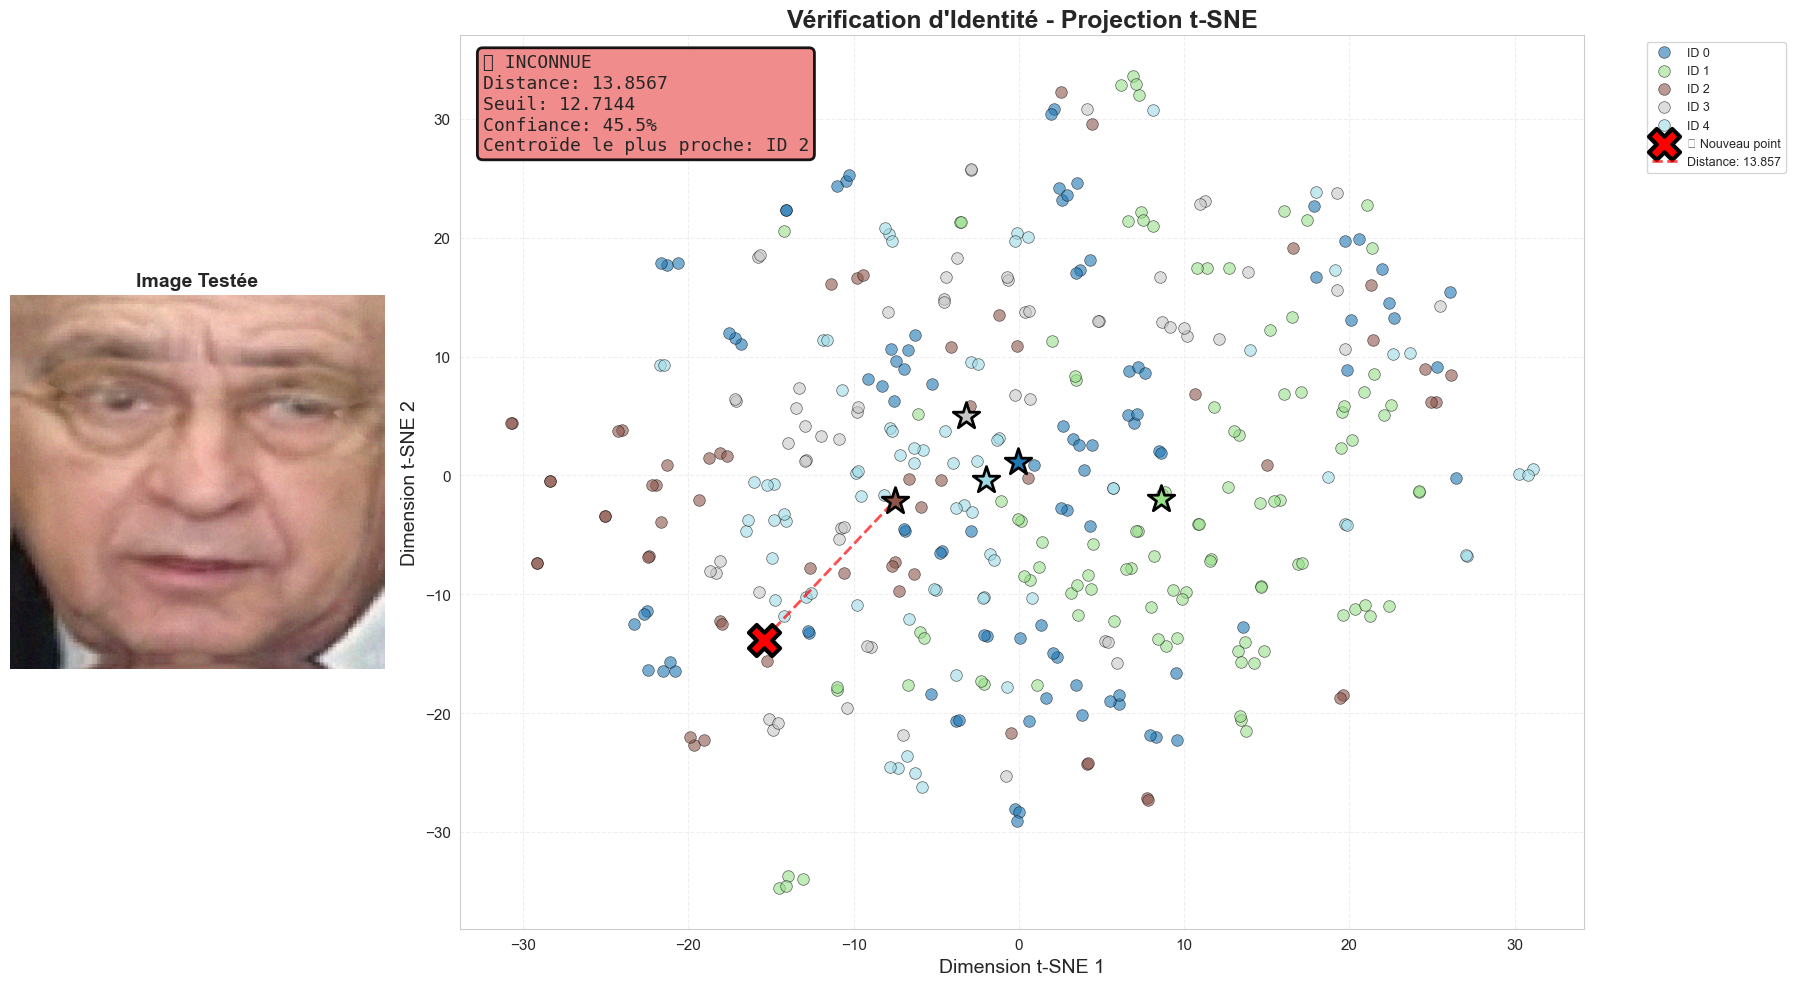

In [15]:
# Choisir une image aléatoire du dataset
test_idx = np.random.randint(0, len(X_all))

result1, fig1 = test_new_image(
    test_idx,
    verifier,
    embedding_model,
    show_image=True
)

### Test 2: Simuler une identité inconnue

On va prendre un embedding existant et ajouter beaucoup de bruit pour simuler une identité complètement différente.


📊 TEST: IDENTITÉ SIMULÉE COMME INCONNUE
Statut: INCONNUE
Distance: 107.0509
Seuil: 12.7144



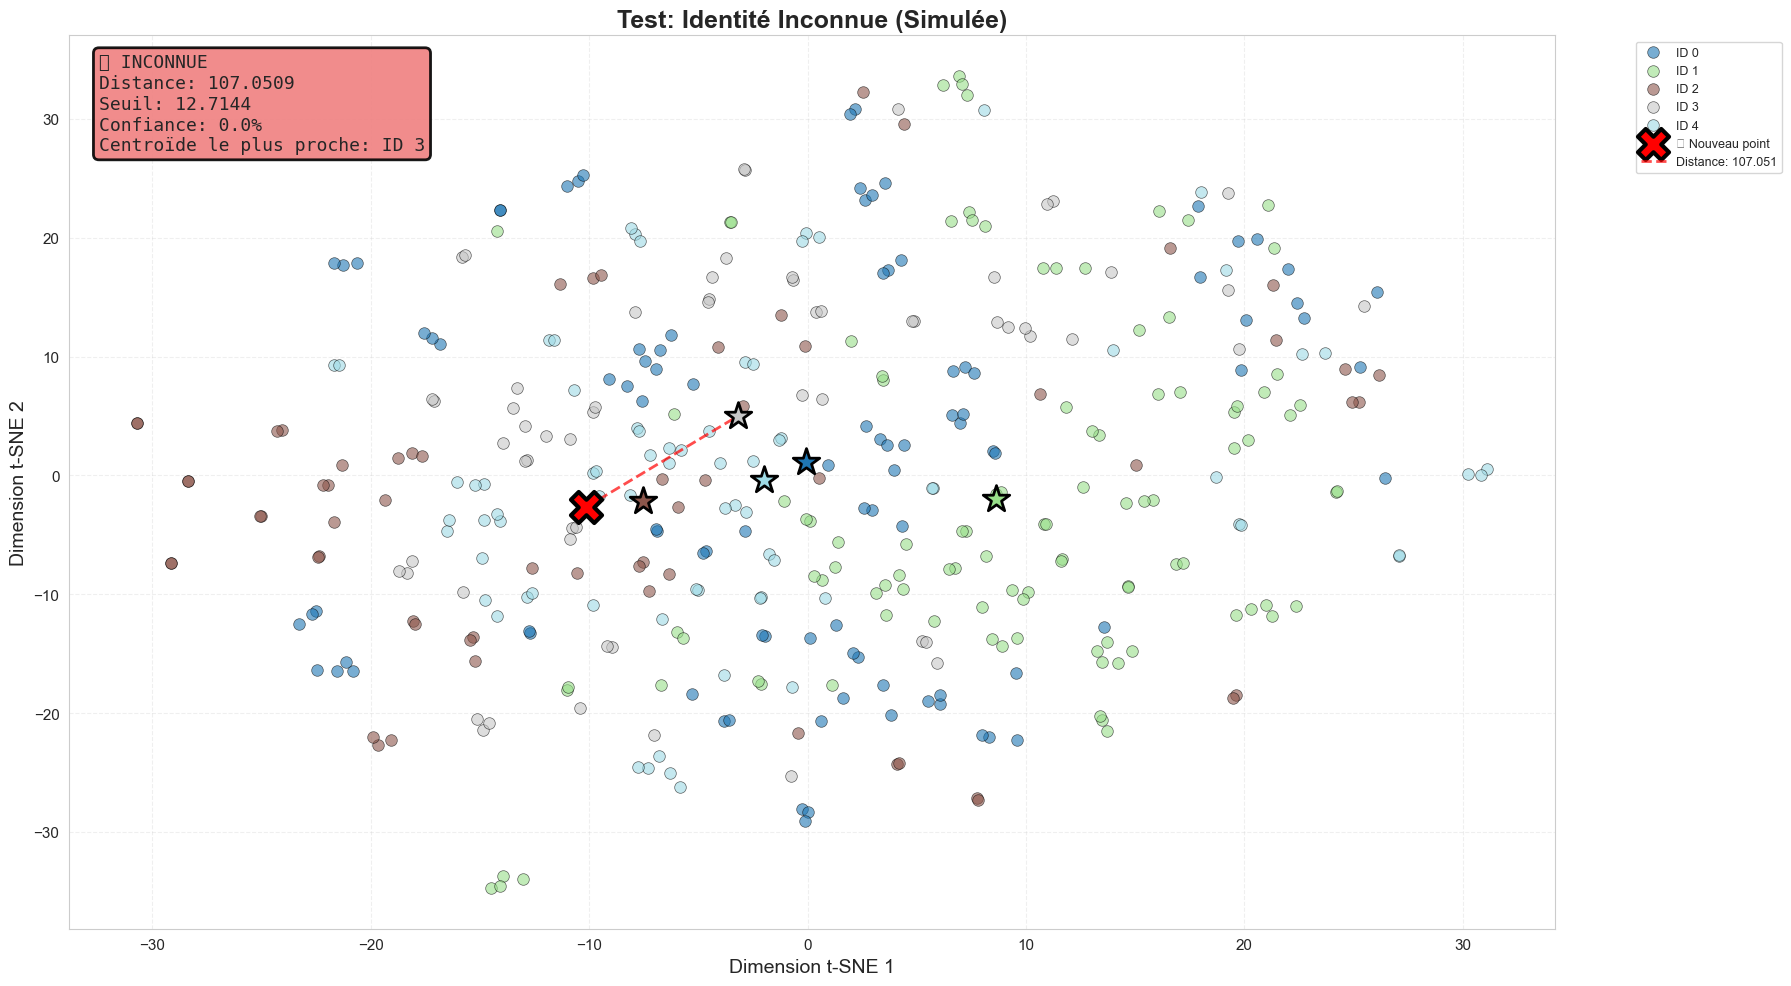

In [16]:
# Créer un embedding "inconnu" en perturbant un embedding existant
base_embedding = embeddings_all[np.random.randint(0, len(embeddings_all))]
unknown_embedding = base_embedding + np.random.randn(len(base_embedding)) * 3.0

# Test
result2 = verifier.verify_identity(unknown_embedding)
unknown_2d = verifier.project_to_2d(unknown_embedding)

print("\n" + "="*60)
print("📊 TEST: IDENTITÉ SIMULÉE COMME INCONNUE")
print("="*60)
print(f"Statut: {'RECONNUE' if result2['is_known'] else 'INCONNUE'}")
print(f"Distance: {result2['distance']:.4f}")
print(f"Seuil: {result2['threshold']:.4f}")
print("="*60 + "\n")

fig2 = verifier.visualize_verification(
    unknown_2d,
    result2,
    title="Test: Identité Inconnue (Simulée)"
)

## 1️⃣2️⃣ Analyse des Performances

### Matrice de confusion sur un sous-ensemble

🔄 Test sur 100 images...

✅ Accuracy: 25.00% (25/100)


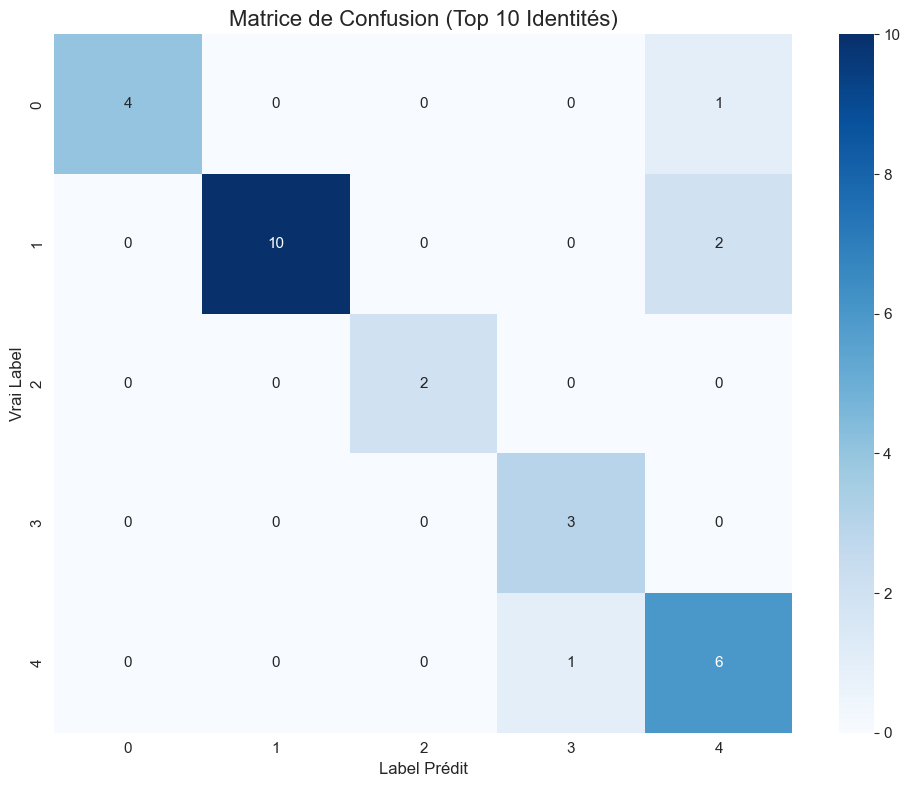

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Test sur 100 images aléatoires
test_indices = np.random.choice(len(X_all), 100, replace=False)

y_true = []
y_pred = []

print("🔄 Test sur 100 images...")
for idx in test_indices:
    img = X_all[idx:idx+1]
    true_id = labels_all[idx]
    
    embedding = embedding_model.predict(img, verbose=0)[0]
    result = verifier.verify_identity(embedding)
    
    y_true.append(true_id)
    y_pred.append(result['identity'] if result['is_known'] else -1)

# Calculer l'accuracy
correct = sum([1 for t, p in zip(y_true, y_pred) if t == p])
accuracy = correct / len(y_true)

print(f"\n✅ Accuracy: {accuracy*100:.2f}% ({correct}/{len(y_true)})")

# Matrice de confusion (seulement pour les top 10 identités)
top_ids = np.unique(labels_all)[:10]
mask = np.isin(y_true, top_ids) & np.isin(y_pred, top_ids)

if mask.sum() > 0:
    y_true_subset = np.array(y_true)[mask]
    y_pred_subset = np.array(y_pred)[mask]
    
    cm = confusion_matrix(y_true_subset, y_pred_subset)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=top_ids, yticklabels=top_ids)
    plt.title('Matrice de Confusion (Top 10 Identités)', fontsize=16)
    plt.ylabel('Vrai Label', fontsize=12)
    plt.xlabel('Label Prédit', fontsize=12)
    plt.tight_layout()
    plt.show()

## 1️⃣3️⃣ Utilisation avec Vos Propres Images

### Exemple d'utilisation

In [18]:
# Pour tester avec votre propre image:

# Option 1: Depuis un fichier
# result, fig = test_new_image(
#     '/path/to/your/image.jpg',
#     verifier,
#     embedding_model
# )

# Option 2: Depuis un array numpy
# your_image = ... # votre image en array (64x64 ou 224x224x3)
# result, fig = test_new_image(
#     your_image,
#     verifier,
#     embedding_model
# )

print("💡 Décommentez le code ci-dessus pour tester vos propres images!")

💡 Décommentez le code ci-dessus pour tester vos propres images!


## 1️⃣4️⃣ Ajustement du Seuil de Sensibilité

Vous pouvez régler la sensibilité du système en ajustant le `threshold_percentile`:

In [19]:
# Plus le percentile est bas, plus le système est strict (moins de faux positifs)
# Plus le percentile est élevé, plus le système est permissif (moins de faux négatifs)

# Système strict (peu de faux positifs)
verifier_strict = IdentityVerifier(
    embeddings_all,
    labels_all,
    embeddings_2d,
    threshold_percentile=10
)

# Système permissif (peu de faux négatifs)
verifier_permissive = IdentityVerifier(
    embeddings_all,
    labels_all,
    embeddings_2d,
    threshold_percentile=30
)

# Comparer les deux
test_idx = np.random.randint(0, len(X_all))
test_embedding = embedding_model.predict(X_all[test_idx:test_idx+1], verbose=0)[0]

result_strict = verifier_strict.verify_identity(test_embedding)
result_permissive = verifier_permissive.verify_identity(test_embedding)

print(f"Image #{test_idx} (ID réel: {labels_all[test_idx]})")
print(f"\nSystème STRICT:")
print(f"  Reconnue: {result_strict['is_known']} (ID: {result_strict['identity']})")
print(f"  Distance: {result_strict['distance']:.4f} | Seuil: {result_strict['threshold']:.4f}")

print(f"\nSystème PERMISSIF:")
print(f"  Reconnue: {result_permissive['is_known']} (ID: {result_permissive['identity']})")
print(f"  Distance: {result_permissive['distance']:.4f} | Seuil: {result_permissive['threshold']:.4f}")

✅ Vérificateur initialisé
   Nombre d'identités: 5
   Seuil de vérification: 11.9349
   Distance intra-classe moyenne: 14.9002
✅ Vérificateur initialisé
   Nombre d'identités: 5
   Seuil de vérification: 13.3095
   Distance intra-classe moyenne: 14.9002
Image #351 (ID réel: 3)

Système STRICT:
  Reconnue: False (ID: None)
  Distance: 14.1811 | Seuil: 11.9349

Système PERMISSIF:
  Reconnue: False (ID: None)
  Distance: 14.1811 | Seuil: 13.3095


## 🎯 Résumé

Ce notebook implémente un système complet de vérification d'identité faciale basé sur:

1. **Extraction d'embeddings** avec MobileNetV2 pré-entraîné
2. **Réduction de dimension** avec t-SNE pour visualisation 2D
3. **Calcul de centroïdes** par identité dans l'espace des embeddings
4. **Seuil de distance** adaptatif basé sur les distances intra-classe
5. **Vérification** de nouvelles images avec visualisation interactive

### 📊 Points clés
- **is_known = True** → L'image correspond à une identité existante
- **is_known = False** → L'image est une nouvelle identité
- Le **seuil** peut être ajusté selon vos besoins (stricte vs permissif)
- La **visualisation t-SNE** permet de voir graphiquement la position du nouveau point

### 🚀 Utilisation
```python
result, fig = test_new_image(
    'votre_image.jpg',  # ou un index, ou un array
    verifier,
    embedding_model
)
```


--- ÉTAPE 1 : Lecture des dossiers ---
✅ Chargé 5 identités depuis big_dataset_lfw
✅ Chargé 10 identités depuis images

--- ÉTAPE 2 : Extraction (MobileNetV2) ---

--- ÉTAPE 3 : Projection t-SNE ---


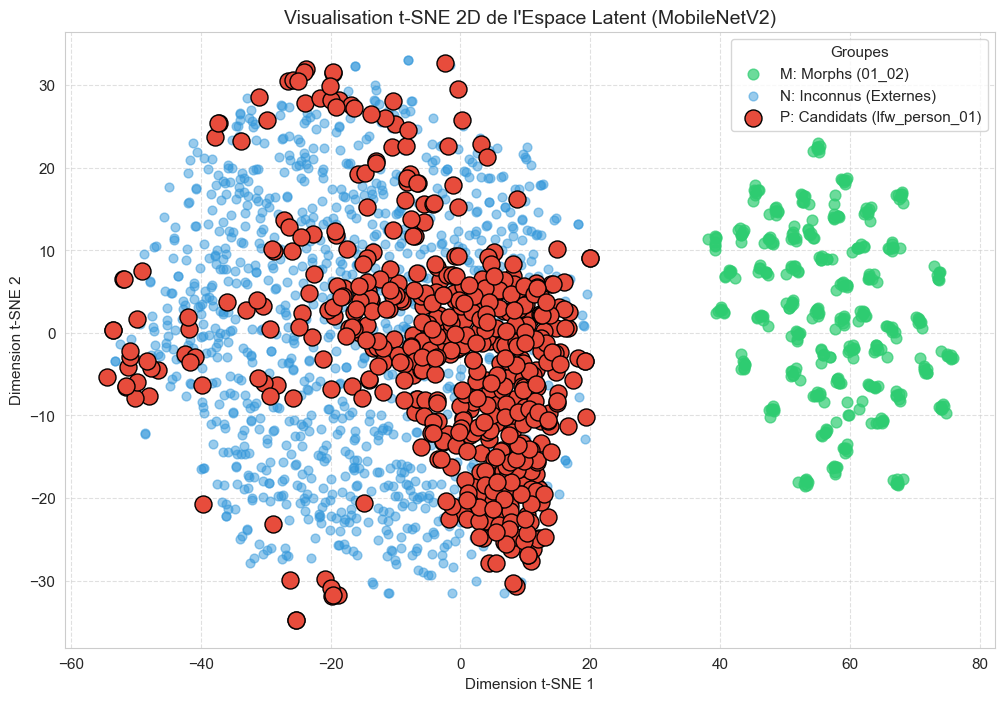


 RÉSULTAT DE L'ANALYSE (SCÉNARIO)
Score de distance vers les Morphs   : 0.4400 (Plus c'est petit, plus c'est proche)
Score de distance vers les Externes : 0.2927

✅ SCÉNARIO PROTECTION :
Les points rouges (P) et bleus (N) sont dispersés ailleurs.
Le morphing a repoussé l'identité originale hors du manifold.


In [28]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.spatial.distance import cosine
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models

# ============================================================
# 1. CONFIGURATION DES CHEMINS
# ============================================================
PATH_MORPHS = r"c:\Users\marwa\OneDrive\Desktop\moprh\big_dataset_lfw" # Contient 5 sous-dossiers
PATH_ORIGINALS = r"C:\Users\marwa\OneDrive\Desktop\moprh\images"       # Contient 10 sous-dossiers
IMG_SIZE = (224, 224)

# ============================================================
# 2. CHARGEMENT DES DONNÉES PAR SOUS-DOSSIER
# ============================================================
def charger_dossiers(base_path):
    """Charge les images en gardant l'organisation par sous-dossier (Identité)."""
    dataset = {}
    valid_ext = {".jpg", ".jpeg", ".png", ".bmp"}
    
    if not os.path.exists(base_path):
        print(f"❌ Chemin introuvable : {base_path}")
        return dataset

    for nom_dossier in os.listdir(base_path):
        chemin_dossier = os.path.join(base_path, nom_dossier)
        if os.path.isdir(chemin_dossier):
            images_identite = []
            for file in os.listdir(chemin_dossier):
                if os.path.splitext(file)[1].lower() in valid_ext:
                    img_path = os.path.join(chemin_dossier, file)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = cv2.resize(img, IMG_SIZE)
                        images_identite.append(img)
            if len(images_identite) > 0:
                dataset[nom_dossier] = np.array(images_identite)
                
    print(f"✅ Chargé {len(dataset)} identités depuis {os.path.basename(base_path)}")
    return dataset

# ============================================================
# 3. MODÈLE D'EXTRACTION
# ============================================================
def build_feature_extractor():
    inputs = layers.Input(shape=(224, 224, 3))
    x = preprocess_input(inputs) # Normalisation cruciale (-1 à 1)
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False
    x = base_model(x)
    outputs = layers.GlobalAveragePooling2D()(x)
    return models.Model(inputs=inputs, outputs=outputs)

# ============================================================
# 4. ANALYSE ET VISUALISATION (Le cœur du programme)
# ============================================================
def analyser_fuite_identite(id_morph_test, id_candidat_test):
    # 1. Charger tout en mémoire
    print("\n--- ÉTAPE 1 : Lecture des dossiers ---")
    data_morphs = charger_dossiers(PATH_MORPHS)
    data_orig = charger_dossiers(PATH_ORIGINALS)

    # Vérifications
    if id_morph_test not in data_morphs:
        print(f"❌ L'identité morphée '{id_morph_test}' n'existe pas. Dossiers dispos : {list(data_morphs.keys())}")
        return
    if id_candidat_test not in data_orig:
        print(f"❌ Le candidat '{id_candidat_test}' n'existe pas. Dossiers dispos : {list(data_orig.keys())}")
        return

    # 2. Séparation des groupes
    imgs_morphs = data_morphs[id_morph_test]        # Groupe M (Vert)
    imgs_candidat = data_orig[id_candidat_test]     # Groupe P (Rouge)
    
    # Grouper les 9 autres originaux pour faire les Externes (Bleu)
    imgs_externes = []
    for nom, images in data_orig.items():
        if nom != id_candidat_test:
            imgs_externes.extend(images)
    imgs_externes = np.array(imgs_externes)

    print(f"\n--- ÉTAPE 2 : Extraction (MobileNetV2) ---")
    extractor = build_feature_extractor()
    
    emb_morphs = extractor.predict(imgs_morphs, verbose=0)
    emb_candidat = extractor.predict(imgs_candidat, verbose=0)
    emb_externes = extractor.predict(imgs_externes, verbose=0)

    # 3. Calcul de distance (pour la conclusion textuelle)
    # On prend la moyenne du candidat vers les morphs vs vers les externes
    dist_morph = np.mean([cosine(c, m) for c in emb_candidat for m in emb_morphs])
    dist_ext = np.mean([cosine(c, e) for c in emb_candidat for e in emb_externes])

    print("\n--- ÉTAPE 3 : Projection t-SNE ---")
    all_data = np.vstack([emb_morphs, emb_externes, emb_candidat])
    tsne = TSNE(n_components=2, perplexity=min(30, len(all_data)-1), random_state=42)
    proj = tsne.fit_transform(all_data)

    # Séparation des index
    idx_m = len(emb_morphs)
    idx_e = idx_m + len(emb_externes)

    p_morph = proj[:idx_m]
    p_ext = proj[idx_m:idx_e]
    p_cand = proj[idx_e:]

    # 4. Affichage du Graphique
    plt.figure(figsize=(12, 8))
    
    # Points Verts (M)
    plt.scatter(p_morph[:, 0], p_morph[:, 1], c='#2ecc71', label=f'M: Morphs ({id_morph_test})', alpha=0.7, s=60)
    
    # Points Bleus (N)
    plt.scatter(p_ext[:, 0], p_ext[:, 1], c='#3498db', label='N: Inconnus (Externes)', alpha=0.5, s=40)
    
    # Points Rouges (P)
    plt.scatter(p_cand[:, 0], p_cand[:, 1], c='#e74c3c', s=150, marker='o', edgecolors='black', 
                label=f'P: Candidats ({id_candidat_test})', zorder=5)

    plt.title(f"Visualisation t-SNE 2D de l'Espace Latent (MobileNetV2)", fontsize=14)
    plt.xlabel("Dimension t-SNE 1")
    plt.ylabel("Dimension t-SNE 2")
    plt.legend(title='Groupes', frameon=True)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # 5. Conclusion
    print("\n" + "="*50)
    print(" RÉSULTAT DE L'ANALYSE (SCÉNARIO)")
    print("="*50)
    print(f"Score de distance vers les Morphs   : {dist_morph:.4f} (Plus c'est petit, plus c'est proche)")
    print(f"Score de distance vers les Externes : {dist_ext:.4f}")
    
    if dist_morph < dist_ext:
        print("\n⚠️ SCÉNARIO FUITE (Leak) :")
        print("Les points rouges (P) sont mélangés ou forment un halo serré autour")
        print("des points verts (M). L'identité a été utilisée pour le morphing.")
    else:
        print("\n✅ SCÉNARIO PROTECTION :")
        print("Les points rouges (P) et bleus (N) sont dispersés ailleurs.")
        print("Le morphing a repoussé l'identité originale hors du manifold.")

# ============================================================
# 5. LANCEMENT DU TEST (À MODIFIER AVEC TES NOMS DE DOSSIERS)
# ============================================================
# ============================================================
# 5. LANCEMENT DU TEST (À MODIFIER AVEC TES NOMS DE DOSSIERS)
# ============================================================
if __name__ == "__main__":
    # Remplacer par le nom EXACT d'un sous-dossier dans big_dataset_lfw
    DOSSIER_MORPH_A_TESTER = "01_02"  # Choix parmi: '01_02', '03_04', '05_06', '07_08', '09_10'
    
    # Remplacer par le nom EXACT d'un sous-dossier dans images
    DOSSIER_ORIGINAL_CANDIDAT = "lfw_person_01"  # Choix parmi: 'lfw_person_01' à 'lfw_person_10'
    
    # Lancement !
    analyser_fuite_identite(DOSSIER_MORPH_A_TESTER, DOSSIER_ORIGINAL_CANDIDAT)

 ANALYSE COMPLÈTE : Détection de fuite d'identité dans les morphs

🔍 Test: lfw_person_01 → 01_02

--- ÉTAPE 1 : Lecture des dossiers ---
✅ Chargé 5 identités depuis big_dataset_lfw
✅ Chargé 10 identités depuis images

--- ÉTAPE 2 : Extraction (MobileNetV2) ---

--- ÉTAPE 3 : Projection t-SNE ---


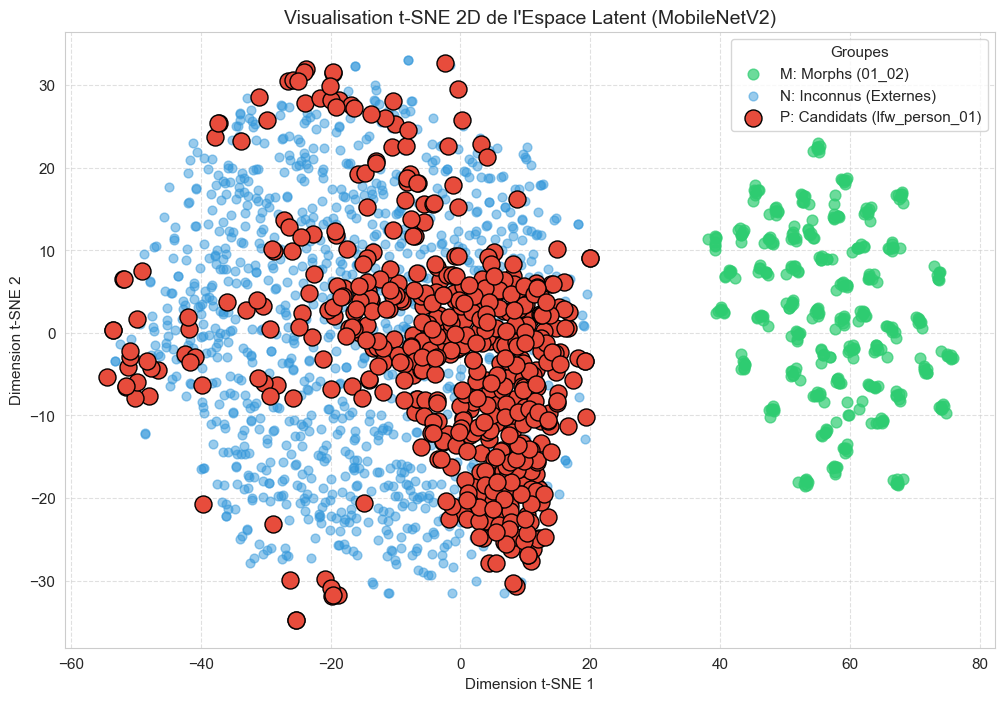


 RÉSULTAT DE L'ANALYSE (SCÉNARIO)
Score de distance vers les Morphs   : 0.4400 (Plus c'est petit, plus c'est proche)
Score de distance vers les Externes : 0.2927

✅ SCÉNARIO PROTECTION :
Les points rouges (P) et bleus (N) sont dispersés ailleurs.
Le morphing a repoussé l'identité originale hors du manifold.

🔍 Test: lfw_person_02 → 01_02

--- ÉTAPE 1 : Lecture des dossiers ---
✅ Chargé 5 identités depuis big_dataset_lfw
✅ Chargé 10 identités depuis images

--- ÉTAPE 2 : Extraction (MobileNetV2) ---

--- ÉTAPE 3 : Projection t-SNE ---


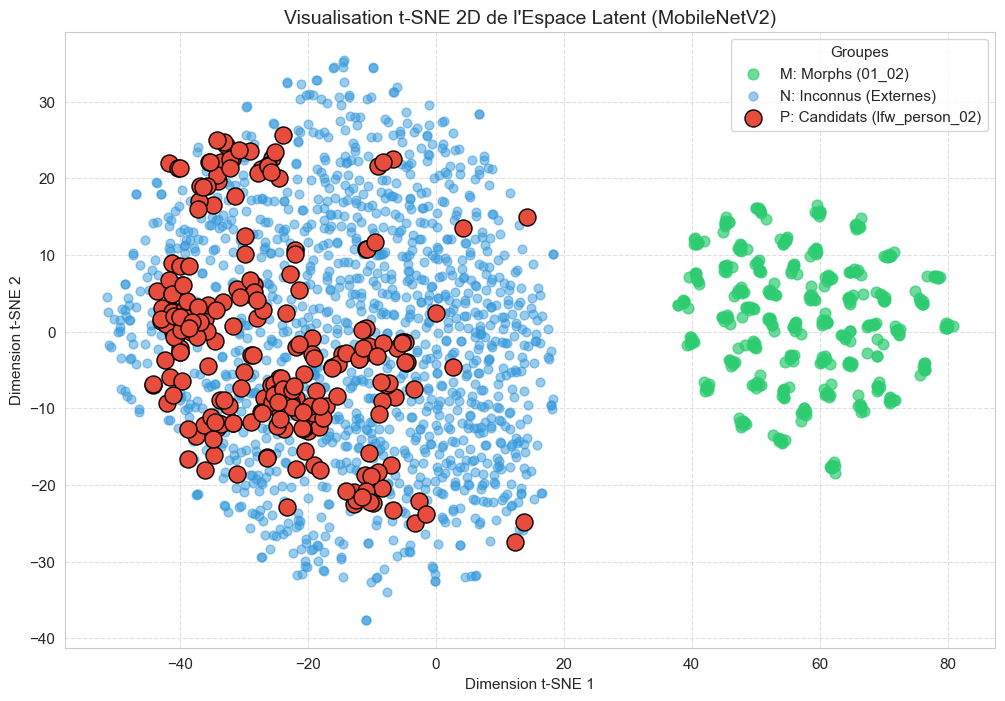


 RÉSULTAT DE L'ANALYSE (SCÉNARIO)
Score de distance vers les Morphs   : 0.4373 (Plus c'est petit, plus c'est proche)
Score de distance vers les Externes : 0.2853

✅ SCÉNARIO PROTECTION :
Les points rouges (P) et bleus (N) sont dispersés ailleurs.
Le morphing a repoussé l'identité originale hors du manifold.

🔍 Test: lfw_person_03 → 03_04

--- ÉTAPE 1 : Lecture des dossiers ---
✅ Chargé 5 identités depuis big_dataset_lfw
✅ Chargé 10 identités depuis images

--- ÉTAPE 2 : Extraction (MobileNetV2) ---

--- ÉTAPE 3 : Projection t-SNE ---


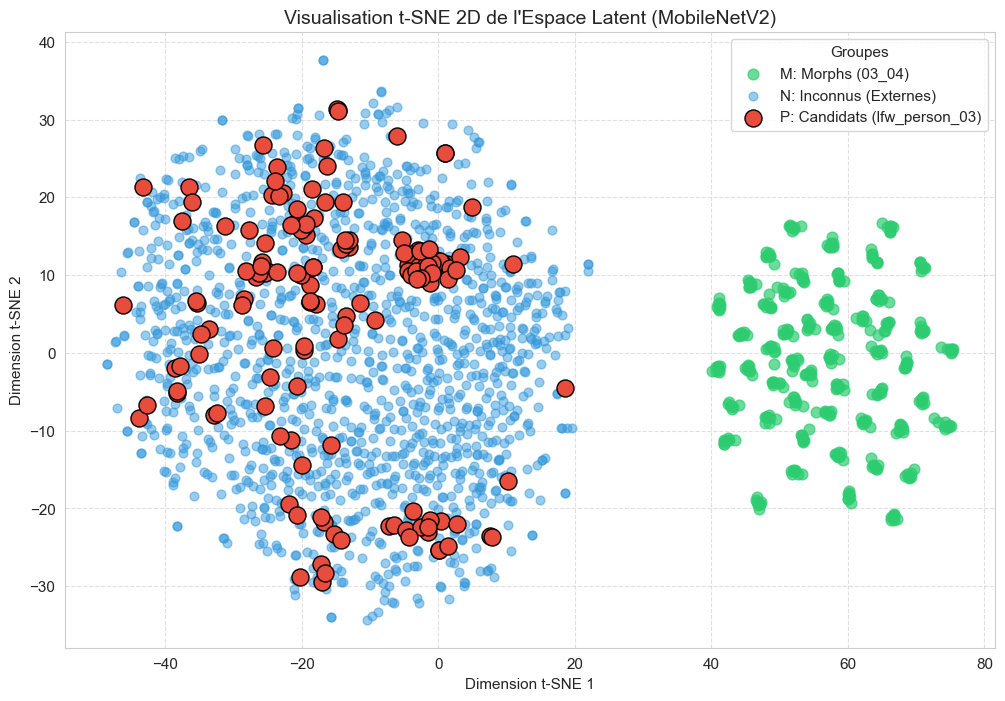


 RÉSULTAT DE L'ANALYSE (SCÉNARIO)
Score de distance vers les Morphs   : 0.4379 (Plus c'est petit, plus c'est proche)
Score de distance vers les Externes : 0.2835

✅ SCÉNARIO PROTECTION :
Les points rouges (P) et bleus (N) sont dispersés ailleurs.
Le morphing a repoussé l'identité originale hors du manifold.

🔍 Test: lfw_person_04 → 03_04

--- ÉTAPE 1 : Lecture des dossiers ---
✅ Chargé 5 identités depuis big_dataset_lfw
✅ Chargé 10 identités depuis images

--- ÉTAPE 2 : Extraction (MobileNetV2) ---

--- ÉTAPE 3 : Projection t-SNE ---


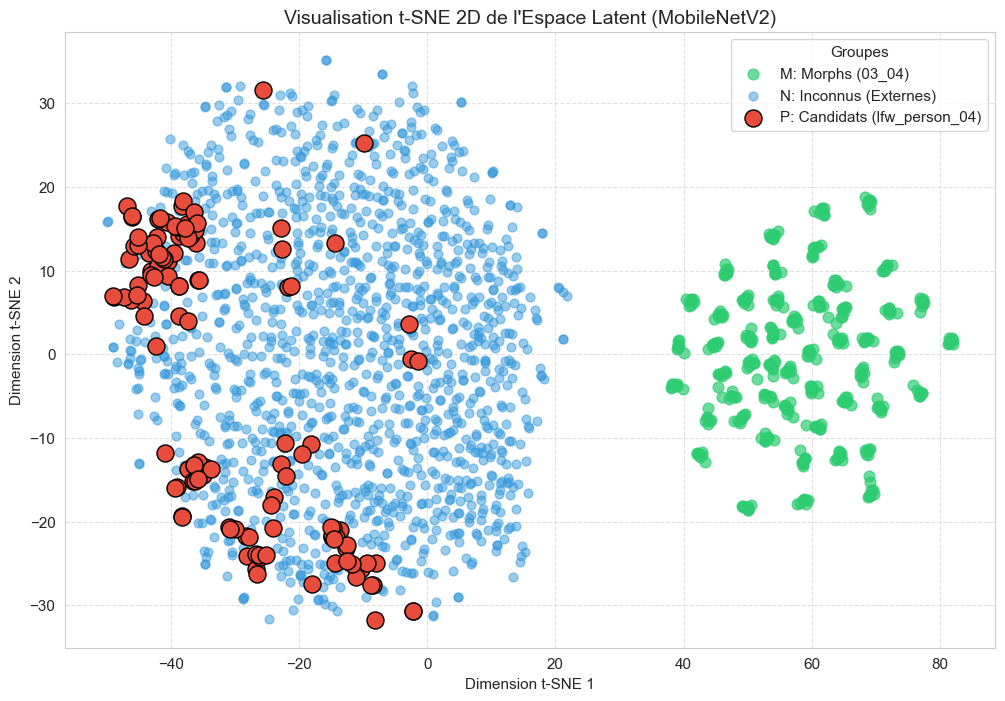


 RÉSULTAT DE L'ANALYSE (SCÉNARIO)
Score de distance vers les Morphs   : 0.4265 (Plus c'est petit, plus c'est proche)
Score de distance vers les Externes : 0.3018

✅ SCÉNARIO PROTECTION :
Les points rouges (P) et bleus (N) sont dispersés ailleurs.
Le morphing a repoussé l'identité originale hors du manifold.

🔍 Test: lfw_person_05 → 05_06

--- ÉTAPE 1 : Lecture des dossiers ---
✅ Chargé 5 identités depuis big_dataset_lfw
✅ Chargé 10 identités depuis images

--- ÉTAPE 2 : Extraction (MobileNetV2) ---

--- ÉTAPE 3 : Projection t-SNE ---


KeyboardInterrupt: 

In [26]:
# Test de toutes les combinaisons morph <-> candidat contributeur
tests = [
    ("01_02", "lfw_person_01"),  # Personne 01 a-t-elle contribué au morph 01_02 ?
    ("01_02", "lfw_person_02"),  # Personne 02 a-t-elle contribué au morph 01_02 ?
    ("03_04", "lfw_person_03"),
    ("03_04", "lfw_person_04"),
    ("05_06", "lfw_person_05"),
    ("05_06", "lfw_person_06"),
]

print("=" * 70)
print(" ANALYSE COMPLÈTE : Détection de fuite d'identité dans les morphs")
print("=" * 70)

for morph_id, candidat_id in tests:
    print(f"\n🔍 Test: {candidat_id} → {morph_id}")
    analyser_fuite_identite(morph_id, candidat_id)